# 🎯 Clustering - Segmentation Clients
## Identification de Groupes Homogènes de Clients

**Objectif :** Segmenter la base clients en groupes homogènes pour adapter les stratégies marketing

**Méthodes :**
1. **K-Means** (partition basée sur les centroïdes)
2. **Hierarchical Clustering** (dendrogramme)
3. **DBSCAN** (détection d'outliers)

---

## 📦 Phase 1 : Imports et Chargement

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Clustering
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist

# Configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

print("✅ Bibliothèques importées")
print(f"📅 {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Bibliothèques importées
📅 2025-10-17 16:37:22


In [2]:
# Chargement des données
df = pd.read_csv('../01_Data/ML_DataSet.csv')

print("=" * 70)
print("CHARGEMENT DES DONNÉES")
print("=" * 70)
print(f"Shape : {df.shape}")
print(f"\nAperçu :")
df.head(3)

CHARGEMENT DES DONNÉES
Shape : (2237, 49)

Aperçu :


,ID_Client,Annee_Naissance,Niveau_Education,Statut_Marital,Revenu,Enfants_Maison,Ados_Maison,Date_Inscription,Jours_Dernier_Achat,Achat_Vins,Achat_Fruits,Achat_Viandes,Achat_Poissons,Achat_Produits_Sucres,Achat_Produits_Or,Achats_Promotions,Achats_En_Ligne,Achats_Catalogue,Achats_En_Magasin,Visites_Web_Mois,Reponse_Campagne_3,Reponse_Campagne_4,Reponse_Campagne_5,Reponse_Campagne_1,Reponse_Campagne_2,Plainte,Cout_Contact_Z,Revenus_Z,Reponse_Derniere_Campagne,Statut_Marital_Texte,Total_Depense,Total_Achats,Depense_Moy_Par_Achat,Total_Campagnes_Acceptees,Jour_Inscription,Revenu_Moyen_Mois,Age_Inscription,Categorie_Age,Niveau_Education_Encode,Statut_Marital_Encode,Jour_Inscription_Encode,Categorie_Age_Encode,Total_Enfants,A_Des_Enfants,Ratio_Vins,Ratio_Viandes,Taux_Reponse_Historique,Engagement_Web,Sensibilite_Promo
0,5524,1957,Graduation,single,58138.00,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1,Single,1617,22,64.68,0,Tuesday,4844.83,55,Senior (51-65),2,0,5,3,0,0,0.39,0.34,0.00,0.36,0.14
1,2174,1954,Graduation,single,46344.00,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0,Single,27,4,4.50,0,Saturday,3862.00,60,Senior (51-65),2,0,2,3,2,1,0.41,0.22,0.00,0.25,0.50
2,4141,1965,Graduation,couple,71613.00,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0,Together,776,20,36.95,0,Wednesday,5967.75,48,Adulte confirmé (36-50),2,1,6,2,0,0,0.55,0.16,0.00,0.40,0.05


## 📊 Phase 2 : Sélection des Features pour Clustering

In [3]:
# Sélectionner les features pertinentes pour le clustering
# On veut segmenter selon le COMPORTEMENT CLIENT

features_clustering = [
    # Démographiques
    'Revenu',
    'Age_Inscription',
    'Total_Enfants',
    
    # Comportement d'achat
    'Total_Depense',
    'Total_Achats',
    'Depense_Moy_Par_Achat',
    
    # Préférences produits
    'Achat_Vins',
    'Achat_Viandes',
    'Achat_Poissons',
    'Achat_Produits_Or',
    
    # Canaux d'achat
    'Achats_En_Ligne',
    'Achats_Catalogue',
    'Achats_En_Magasin',
    
    # Engagement
    'Visites_Web_Mois',
    'Engagement_Web',
    'Sensibilite_Promo',
    
    # Historique campagnes
    'Total_Campagnes_Acceptees',
    'Taux_Reponse_Historique'
]

print("=" * 70)
print("SÉLECTION DES FEATURES POUR CLUSTERING")
print("=" * 70)
print(f"\nNombre de features : {len(features_clustering)}")
print("\nFeatures sélectionnées :")
for i, feat in enumerate(features_clustering, 1):
    print(f"  {i:2d}. {feat}")

# Créer le dataset pour clustering
X_cluster = df[features_clustering].copy()

# Gérer les valeurs manquantes
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
X_cluster = pd.DataFrame(
    imputer.fit_transform(X_cluster),
    columns=features_clustering,
    index=X_cluster.index
)

print(f"\n✅ Dataset préparé : {X_cluster.shape}")
print(f"✅ Valeurs manquantes : {X_cluster.isnull().sum().sum()}")

SÉLECTION DES FEATURES POUR CLUSTERING

Nombre de features : 18

Features sélectionnées :
   1. Revenu
   2. Age_Inscription
   3. Total_Enfants
   4. Total_Depense
   5. Total_Achats
   6. Depense_Moy_Par_Achat
   7. Achat_Vins
   8. Achat_Viandes
   9. Achat_Poissons
  10. Achat_Produits_Or
  11. Achats_En_Ligne
  12. Achats_Catalogue
  13. Achats_En_Magasin
  14. Visites_Web_Mois
  15. Engagement_Web
  16. Sensibilite_Promo
  17. Total_Campagnes_Acceptees
  18. Taux_Reponse_Historique

✅ Dataset préparé : (2237, 18)
✅ Valeurs manquantes : 0


In [4]:
# Statistiques descriptives des features
print("\n📊 STATISTIQUES DES FEATURES")
print("=" * 70)
X_cluster.describe().T


📊 STATISTIQUES DES FEATURES


,count,mean,std,min,25%,50%,75%,max
Revenu,2237.00,51676.15,25615.06,0.00,34704.00,51039.00,68281.00,666666.00
Age_Inscription,2237.00,44.13,11.74,16.00,36.00,43.00,54.00,73.00
Total_Enfants,2237.00,0.95,0.75,0.00,0.00,1.00,1.00,3.00
Total_Depense,2237.00,605.74,601.84,5.00,69.00,396.00,1045.00,2525.00
Total_Achats,2237.00,12.54,7.21,0.00,6.00,12.00,18.00,32.00
Depense_Moy_Par_Achat,2237.00,33.30,44.98,0.53,9.71,23.38,45.22,1679.00
Achat_Vins,2237.00,304.00,336.57,0.00,24.00,174.00,504.00,1493.00
Achat_Viandes,2237.00,166.92,225.66,0.00,16.00,67.00,232.00,1725.00
Achat_Poissons,2237.00,37.52,54.64,0.00,3.00,12.00,50.00,259.00
Achat_Produits_Or,2237.00,43.97,52.05,0.00,9.00,24.00,56.00,362.00


## 🔧 Phase 3 : Normalisation (OBLIGATOIRE pour Clustering)

In [5]:
# Normalisation avec StandardScaler
# CRUCIAL : les algorithmes de clustering sont sensibles à l'échelle !

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# Convertir en DataFrame pour garder les noms de colonnes
X_scaled_df = pd.DataFrame(
    X_scaled,
    columns=features_clustering,
    index=X_cluster.index
)

print("=" * 70)
print("NORMALISATION DES DONNÉES")
print("=" * 70)
print(f"\nAvant normalisation :")
print(f"  Revenu : min={X_cluster['Revenu'].min():.0f}, max={X_cluster['Revenu'].max():.0f}")
print(f"  Total_Depense : min={X_cluster['Total_Depense'].min():.0f}, max={X_cluster['Total_Depense'].max():.0f}")

print(f"\nAprès normalisation :")
print(f"  Revenu : min={X_scaled_df['Revenu'].min():.2f}, max={X_scaled_df['Revenu'].max():.2f}")
print(f"  Total_Depense : min={X_scaled_df['Total_Depense'].min():.2f}, max={X_scaled_df['Total_Depense'].max():.2f}")

print("\n✅ Données normalisées (moyenne=0, écart-type=1)")

NORMALISATION DES DONNÉES

Avant normalisation :
  Revenu : min=0, max=666666
  Total_Depense : min=5, max=2525

Après normalisation :
  Revenu : min=-2.02, max=24.01
  Total_Depense : min=-1.00, max=3.19

✅ Données normalisées (moyenne=0, écart-type=1)


---
## 🎯 Phase 4 : K-Means Clustering

### Étape 1 : Méthode du Coude (Elbow Method) pour trouver K optimal

In [6]:
# Tester différentes valeurs de K
K_range = range(2, 11)
inertias = []
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

print("=" * 70)
print("RECHERCHE DU NOMBRE OPTIMAL DE CLUSTERS (K)")
print("=" * 70)
print("\n⏳ Test de K=2 à K=10...\n")

for k in K_range:
    # K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    # Métriques
    inertia = kmeans.inertia_
    silhouette = silhouette_score(X_scaled, labels)
    davies_bouldin = davies_bouldin_score(X_scaled, labels)
    calinski_harabasz = calinski_harabasz_score(X_scaled, labels)
    
    inertias.append(inertia)
    silhouette_scores.append(silhouette)
    davies_bouldin_scores.append(davies_bouldin)
    calinski_harabasz_scores.append(calinski_harabasz)
    
    print(f"K={k:2d} | Inertia={inertia:8.0f} | Silhouette={silhouette:.3f} | DB={davies_bouldin:.3f} | CH={calinski_harabasz:.0f}")

print("\n✅ Tests terminés")

RECHERCHE DU NOMBRE OPTIMAL DE CLUSTERS (K)

⏳ Test de K=2 à K=10...

K= 2 | Inertia=   26774 | Silhouette=0.352 | DB=1.249 | CH=1126
K= 3 | Inertia=   23702 | Silhouette=0.266 | DB=1.696 | CH=781
K= 4 | Inertia=   21484 | Silhouette=0.267 | DB=1.594 | CH=651
K= 5 | Inertia=   20146 | Silhouette=0.266 | DB=1.287 | CH=557
K= 6 | Inertia=   18699 | Silhouette=0.198 | DB=1.555 | CH=515
K= 7 | Inertia=   17756 | Silhouette=0.155 | DB=1.632 | CH=471
K= 8 | Inertia=   16420 | Silhouette=0.156 | DB=1.435 | CH=462
K= 9 | Inertia=   16569 | Silhouette=0.159 | DB=1.619 | CH=398
K=10 | Inertia=   15233 | Silhouette=0.155 | DB=1.573 | CH=407

✅ Tests terminés


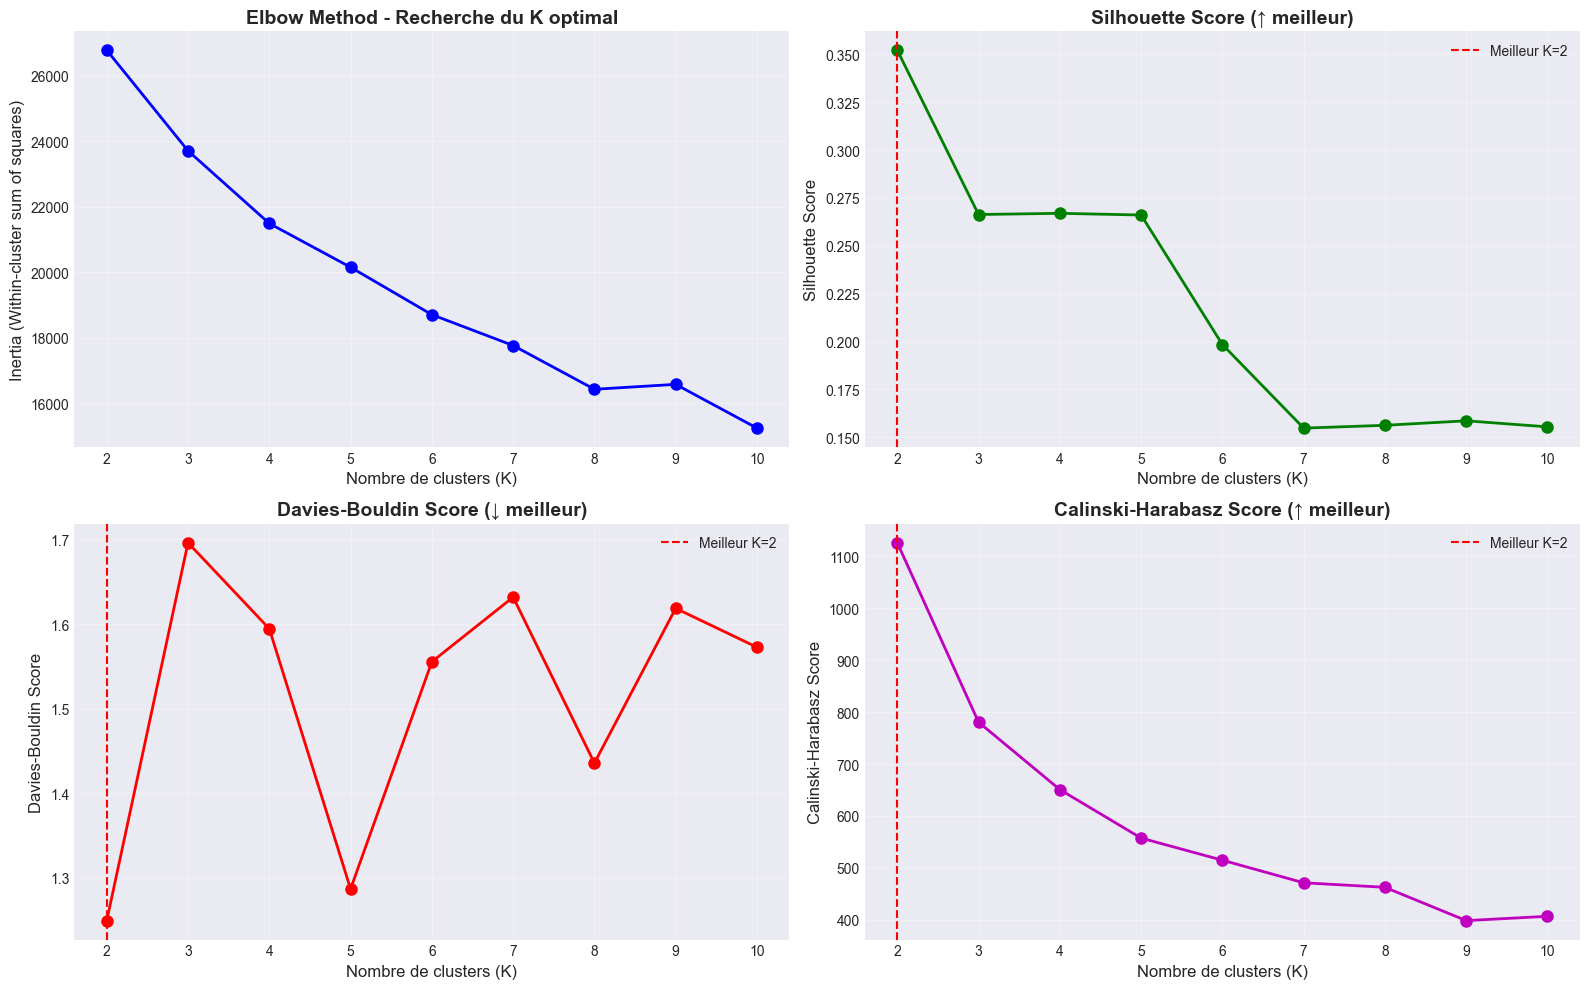


RECOMMANDATIONS POUR K OPTIMAL
  Silhouette Score      → K=2
  Davies-Bouldin Score  → K=2
  Calinski-Harabasz     → K=2

💡 K recommandé : 3 ou 4 (basé sur le 'coude' et les métriques)


In [7]:
# Visualisation des métriques
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Elbow Method (Inertia)
axes[0, 0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Nombre de clusters (K)', fontsize=12)
axes[0, 0].set_ylabel('Inertia (Within-cluster sum of squares)', fontsize=12)
axes[0, 0].set_title('Elbow Method - Recherche du K optimal', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(K_range)

# 2. Silhouette Score (plus élevé = meilleur)
axes[0, 1].plot(K_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Nombre de clusters (K)', fontsize=12)
axes[0, 1].set_ylabel('Silhouette Score', fontsize=12)
axes[0, 1].set_title('Silhouette Score (↑ meilleur)', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks(K_range)
best_k_silhouette = K_range[np.argmax(silhouette_scores)]
axes[0, 1].axvline(best_k_silhouette, color='red', linestyle='--', label=f'Meilleur K={best_k_silhouette}')
axes[0, 1].legend()

# 3. Davies-Bouldin Score (plus bas = meilleur)
axes[1, 0].plot(K_range, davies_bouldin_scores, 'ro-', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Nombre de clusters (K)', fontsize=12)
axes[1, 0].set_ylabel('Davies-Bouldin Score', fontsize=12)
axes[1, 0].set_title('Davies-Bouldin Score (↓ meilleur)', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xticks(K_range)
best_k_db = K_range[np.argmin(davies_bouldin_scores)]
axes[1, 0].axvline(best_k_db, color='red', linestyle='--', label=f'Meilleur K={best_k_db}')
axes[1, 0].legend()

# 4. Calinski-Harabasz Score (plus élevé = meilleur)
axes[1, 1].plot(K_range, calinski_harabasz_scores, 'mo-', linewidth=2, markersize=8)
axes[1, 1].set_xlabel('Nombre de clusters (K)', fontsize=12)
axes[1, 1].set_ylabel('Calinski-Harabasz Score', fontsize=12)
axes[1, 1].set_title('Calinski-Harabasz Score (↑ meilleur)', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xticks(K_range)
best_k_ch = K_range[np.argmax(calinski_harabasz_scores)]
axes[1, 1].axvline(best_k_ch, color='red', linestyle='--', label=f'Meilleur K={best_k_ch}')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("RECOMMANDATIONS POUR K OPTIMAL")
print("=" * 70)
print(f"  Silhouette Score      → K={best_k_silhouette}")
print(f"  Davies-Bouldin Score  → K={best_k_db}")
print(f"  Calinski-Harabasz     → K={best_k_ch}")
print(f"\n💡 K recommandé : 3 ou 4 (basé sur le 'coude' et les métriques)")

### Étape 2 : Clustering Final avec K optimal

In [8]:
# Choisir K optimal (ajuster selon les graphiques ci-dessus)
K_OPTIMAL = 4  # À ajuster selon vos résultats

print("=" * 70)
print(f"K-MEANS CLUSTERING FINAL (K={K_OPTIMAL})")
print("=" * 70)

# K-Means final
kmeans_final = KMeans(n_clusters=K_OPTIMAL, random_state=42, n_init=20)
clusters_kmeans = kmeans_final.fit_predict(X_scaled)

# Ajouter au DataFrame
df['Cluster_KMeans'] = clusters_kmeans

# Métriques finales
silhouette_final = silhouette_score(X_scaled, clusters_kmeans)
davies_bouldin_final = davies_bouldin_score(X_scaled, clusters_kmeans)
calinski_harabasz_final = calinski_harabasz_score(X_scaled, clusters_kmeans)

print(f"\n📊 Métriques du clustering final :")
print(f"   Silhouette Score      : {silhouette_final:.3f}")
print(f"   Davies-Bouldin Score  : {davies_bouldin_final:.3f}")
print(f"   Calinski-Harabasz     : {calinski_harabasz_final:.0f}")

print(f"\n📋 Distribution des clusters :")
print(df['Cluster_KMeans'].value_counts().sort_index())

print("\n✅ Clustering K-Means terminé")

K-MEANS CLUSTERING FINAL (K=4)

📊 Métriques du clustering final :
   Silhouette Score      : 0.267
   Davies-Bouldin Score  : 1.594
   Calinski-Harabasz     : 651

📋 Distribution des clusters :
Cluster_KMeans
0    1059
1     128
2     601
3     449
Name: count, dtype: int64

✅ Clustering K-Means terminé


---
## 📊 Phase 5 : Analyse des Clusters

### Profil de chaque segment

In [9]:
# Créer un profil détaillé de chaque cluster
print("=" * 70)
print("PROFIL DES CLUSTERS")
print("=" * 70)

for cluster_id in range(K_OPTIMAL):
    cluster_data = df[df['Cluster_KMeans'] == cluster_id]
    n_clients = len(cluster_data)
    pct_clients = (n_clients / len(df)) * 100
    
    print(f"\n{'='*70}")
    print(f"🎯 CLUSTER {cluster_id}")
    print(f"{'='*70}")
    print(f"\n📈 Taille : {n_clients} clients ({pct_clients:.1f}% de la base)")
    
    print(f"\n💰 PROFIL FINANCIER :")
    print(f"   Revenu moyen             : {cluster_data['Revenu'].mean():>10,.0f} €")
    print(f"   Dépense totale moyenne   : {cluster_data['Total_Depense'].mean():>10,.0f} €")
    print(f"   Dépense moy. par achat   : {cluster_data['Depense_Moy_Par_Achat'].mean():>10,.2f} €")
    print(f"   Nombre d'achats moyen    : {cluster_data['Total_Achats'].mean():>10,.1f}")
    
    print(f"\n👤 PROFIL DÉMOGRAPHIQUE :")
    print(f"   Âge moyen                : {cluster_data['Age_Inscription'].mean():>10,.1f} ans")
    print(f"   Enfants moyens           : {cluster_data['Total_Enfants'].mean():>10,.2f}")
    
    print(f"\n🛒 PRÉFÉRENCES PRODUITS :")
    print(f"   Achat Vins               : {cluster_data['Achat_Vins'].mean():>10,.0f} €")
    print(f"   Achat Viandes            : {cluster_data['Achat_Viandes'].mean():>10,.0f} €")
    print(f"   Achat Poissons           : {cluster_data['Achat_Poissons'].mean():>10,.0f} €")
    print(f"   Achat Produits Or        : {cluster_data['Achat_Produits_Or'].mean():>10,.0f} €")
    
    print(f"\n🌐 COMPORTEMENT DIGITAL :")
    print(f"   Achats en ligne          : {cluster_data['Achats_En_Ligne'].mean():>10,.1f}")
    print(f"   Achats catalogue         : {cluster_data['Achats_Catalogue'].mean():>10,.1f}")
    print(f"   Achats en magasin        : {cluster_data['Achats_En_Magasin'].mean():>10,.1f}")
    print(f"   Visites web/mois         : {cluster_data['Visites_Web_Mois'].mean():>10,.1f}")
    print(f"   Engagement web           : {cluster_data['Engagement_Web'].mean():>10,.2%}")
    
    print(f"\n📢 RÉACTIVITÉ MARKETING :")
    print(f"   Taux de réponse          : {cluster_data['Reponse_Derniere_Campagne'].mean():>10,.2%}")
    print(f"   Campagnes acceptées      : {cluster_data['Total_Campagnes_Acceptees'].mean():>10,.2f}")
    print(f"   Sensibilité promo        : {cluster_data['Sensibilite_Promo'].mean():>10,.2f}")

print("\n" + "=" * 70)
print("✅ Analyse des clusters terminée")

PROFIL DES CLUSTERS

🎯 CLUSTER 0

📈 Taille : 1059 clients (47.3% de la base)

💰 PROFIL FINANCIER :
   Revenu moyen             :     34,858 €
   Dépense totale moyenne   :         99 €
   Dépense moy. par achat   :      11.13 €
   Nombre d'achats moyen    :        5.9

👤 PROFIL DÉMOGRAPHIQUE :
   Âge moyen                :       42.0 ans
   Enfants moyens           :       1.26

🛒 PRÉFÉRENCES PRODUITS :
   Achat Vins               :         44 €
   Achat Viandes            :         23 €
   Achat Poissons           :          7 €
   Achat Produits Or        :         15 €

🌐 COMPORTEMENT DIGITAL :
   Achats en ligne          :        2.1
   Achats catalogue         :        0.6
   Achats en magasin        :        3.3
   Visites web/mois         :        6.4
   Engagement web           :     33.68%

📢 RÉACTIVITÉ MARKETING :
   Taux de réponse          :      9.07%
   Campagnes acceptées      :       0.08
   Sensibilité promo        :       0.36

🎯 CLUSTER 1

📈 Taille : 128 clients (5.7

In [10]:
# Tableau comparatif des clusters
features_compare = [
    'Revenu', 'Total_Depense', 'Age_Inscription',
    'Total_Achats', 'Achat_Vins', 'Achat_Viandes',
    'Engagement_Web', 'Reponse_Derniere_Campagne'
]

cluster_profiles = df.groupby('Cluster_KMeans')[features_compare].mean()

print("\n📊 TABLEAU COMPARATIF DES CLUSTERS")
print("=" * 70)
cluster_profiles.T


📊 TABLEAU COMPARATIF DES CLUSTERS


Cluster_KMeans,0,1,2,3
Revenu,34857.55,79723.60,57293.67,75829.17
Total_Depense,98.86,1616.19,734.66,1340.64
Age_Inscription,41.96,42.41,47.48,45.23
Total_Achats,5.94,19.76,17.40,19.57
Achat_Vins,43.77,920.14,439.33,560.95
Achat_Viandes,23.10,429.93,140.85,466.03
Engagement_Web,0.34,0.28,0.39,0.25
Reponse_Derniere_Campagne,0.09,0.63,0.12,0.18


### Visualisations des Clusters

In [11]:
# PCA pour visualiser en 2D
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Variance expliquée
var_explained = pca.explained_variance_ratio_

print("=" * 70)
print("PCA - RÉDUCTION DE DIMENSION")
print("=" * 70)
print(f"\nVariance expliquée par PC1 : {var_explained[0]:.2%}")
print(f"Variance expliquée par PC2 : {var_explained[1]:.2%}")
print(f"Variance totale expliquée  : {var_explained.sum():.2%}")
print("\n✅ PCA calculée")

PCA - RÉDUCTION DE DIMENSION

Variance expliquée par PC1 : 42.55%
Variance expliquée par PC2 : 10.65%
Variance totale expliquée  : 53.20%

✅ PCA calculée


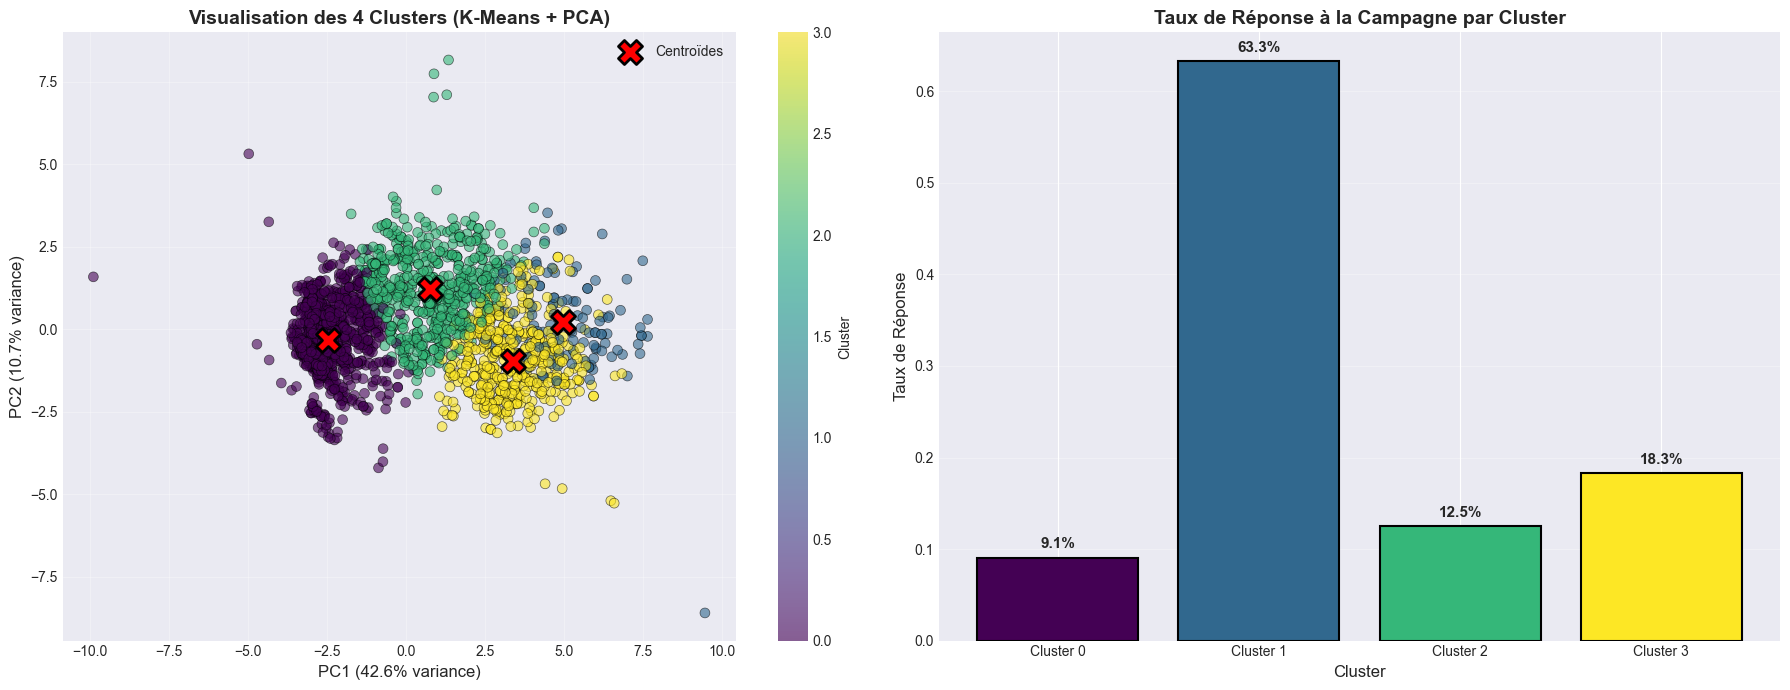


✅ Visualisations créées


In [12]:
# Visualisation PCA 2D avec clusters
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot 1 : Clusters K-Means
scatter = axes[0].scatter(
    X_pca[:, 0], 
    X_pca[:, 1], 
    c=clusters_kmeans, 
    cmap='viridis', 
    s=50, 
    alpha=0.6,
    edgecolors='black',
    linewidth=0.5
)

# Ajouter les centroïdes
centroids_pca = pca.transform(kmeans_final.cluster_centers_)
axes[0].scatter(
    centroids_pca[:, 0],
    centroids_pca[:, 1],
    c='red',
    s=300,
    marker='X',
    edgecolors='black',
    linewidth=2,
    label='Centroïdes'
)

axes[0].set_xlabel(f'PC1 ({var_explained[0]:.1%} variance)', fontsize=12)
axes[0].set_ylabel(f'PC2 ({var_explained[1]:.1%} variance)', fontsize=12)
axes[0].set_title(f'Visualisation des {K_OPTIMAL} Clusters (K-Means + PCA)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[0], label='Cluster')

# Plot 2 : Distribution de la cible par cluster
response_by_cluster = df.groupby('Cluster_KMeans')['Reponse_Derniere_Campagne'].mean()
colors_bar = plt.cm.viridis(np.linspace(0, 1, K_OPTIMAL))
axes[1].bar(range(K_OPTIMAL), response_by_cluster.values, color=colors_bar, edgecolor='black', linewidth=1.5)
axes[1].set_xlabel('Cluster', fontsize=12)
axes[1].set_ylabel('Taux de Réponse', fontsize=12)
axes[1].set_title('Taux de Réponse à la Campagne par Cluster', fontsize=14, fontweight='bold')
axes[1].set_xticks(range(K_OPTIMAL))
axes[1].set_xticklabels([f'Cluster {i}' for i in range(K_OPTIMAL)])
axes[1].grid(True, alpha=0.3, axis='y')

# Ajouter les valeurs sur les barres
for i, v in enumerate(response_by_cluster.values):
    axes[1].text(i, v + 0.01, f'{v:.1%}', ha='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

print("\n✅ Visualisations créées")

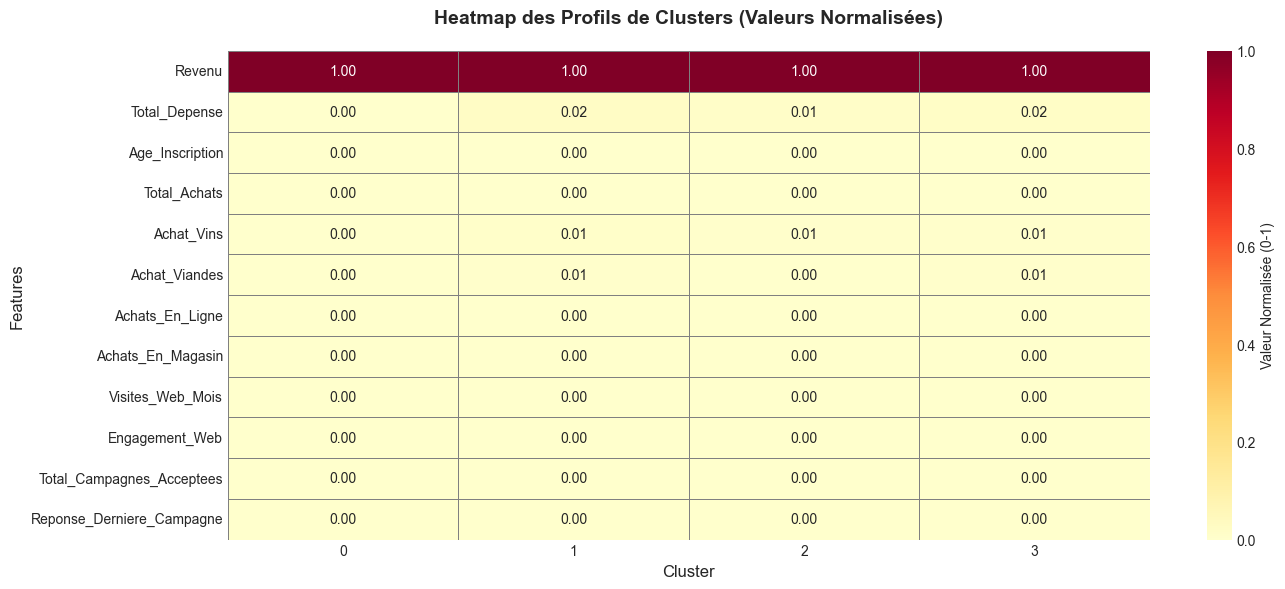


💡 Interprétation de la heatmap :
   - Rouge foncé = valeur élevée
   - Jaune clair = valeur faible
   - Permet de comparer les clusters visuellement


In [13]:
# Heatmap des profils de clusters
features_heatmap = [
    'Revenu', 'Total_Depense', 'Age_Inscription', 'Total_Achats',
    'Achat_Vins', 'Achat_Viandes', 'Achats_En_Ligne', 'Achats_En_Magasin',
    'Visites_Web_Mois', 'Engagement_Web', 'Total_Campagnes_Acceptees',
    'Reponse_Derniere_Campagne'
]

# Calculer les moyennes normalisées par cluster
cluster_means = df.groupby('Cluster_KMeans')[features_heatmap].mean()

# Normaliser pour la heatmap (entre 0 et 1)
from sklearn.preprocessing import MinMaxScaler
scaler_viz = MinMaxScaler()
cluster_means_norm = pd.DataFrame(
    scaler_viz.fit_transform(cluster_means.T).T,
    columns=cluster_means.columns,
    index=cluster_means.index
)

# Heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(
    cluster_means_norm.T,
    annot=True,
    fmt='.2f',
    cmap='YlOrRd',
    cbar_kws={'label': 'Valeur Normalisée (0-1)'},
    linewidths=0.5,
    linecolor='gray'
)
plt.title('Heatmap des Profils de Clusters (Valeurs Normalisées)', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()

print("\n💡 Interprétation de la heatmap :")
print("   - Rouge foncé = valeur élevée")
print("   - Jaune clair = valeur faible")
print("   - Permet de comparer les clusters visuellement")

---
## 🌳 Phase 6 : Hierarchical Clustering (BONUS)

HIERARCHICAL CLUSTERING

⏳ Calcul du dendrogramme (peut prendre 30s-1min)...



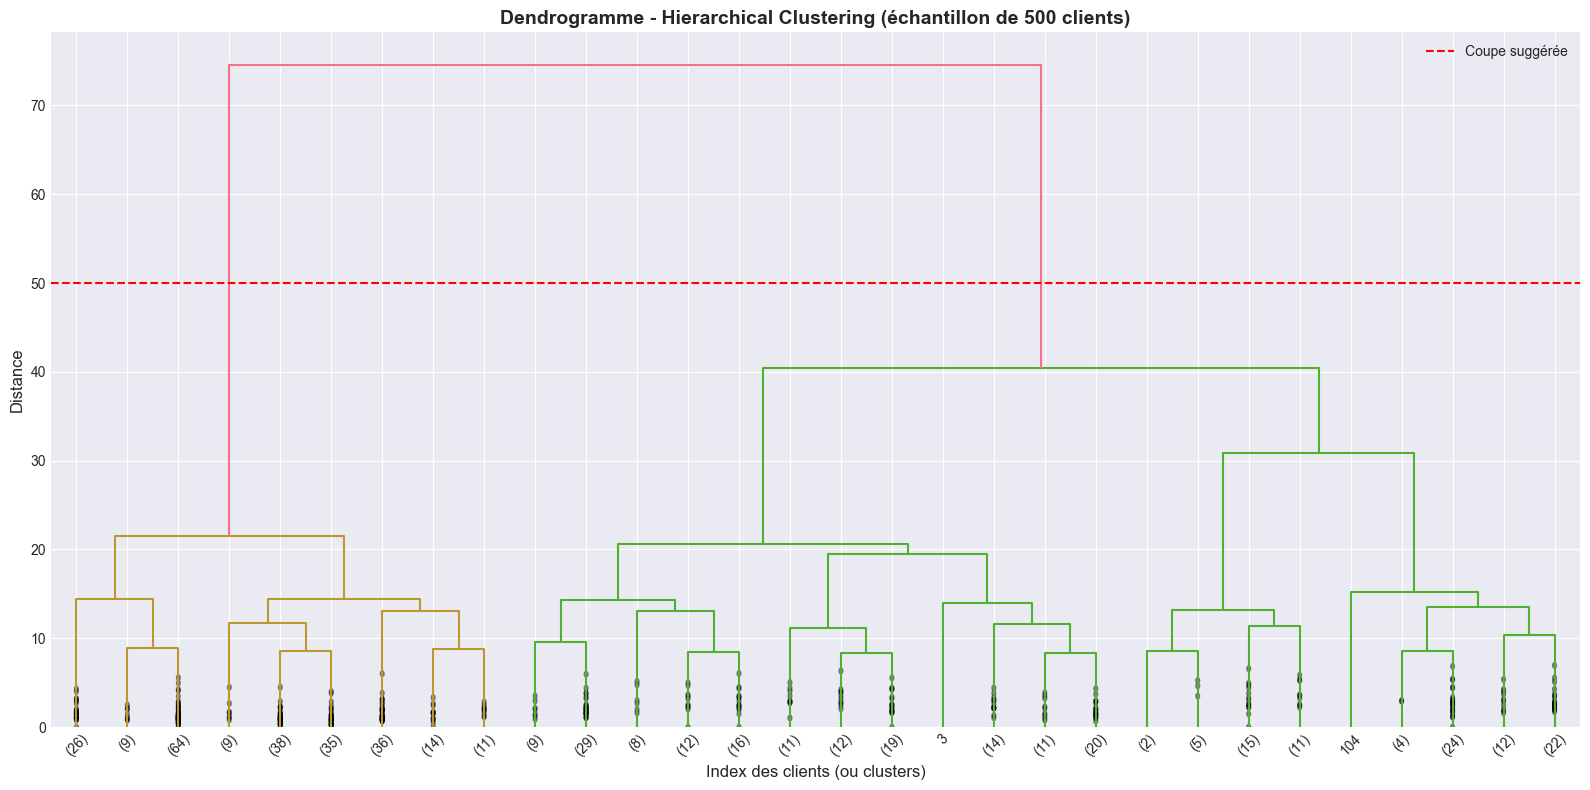


✅ Dendrogramme créé
💡 Observation : Le dendrogramme confirme la structure en 3-4 clusters


In [14]:
# Hierarchical Clustering avec dendrogramme
print("=" * 70)
print("HIERARCHICAL CLUSTERING")
print("=" * 70)
print("\n⏳ Calcul du dendrogramme (peut prendre 30s-1min)...\n")

# Utiliser un échantillon pour le dendrogramme (trop lourd sinon)
sample_size = min(500, len(X_scaled))
sample_idx = np.random.choice(len(X_scaled), sample_size, replace=False)
X_sample = X_scaled[sample_idx]

# Linkage
linkage_matrix = linkage(X_sample, method='ward')

# Dendrogramme
plt.figure(figsize=(16, 8))
dendrogram(
    linkage_matrix,
    truncate_mode='lastp',
    p=30,
    leaf_font_size=10,
    show_contracted=True
)
plt.title(f'Dendrogramme - Hierarchical Clustering (échantillon de {sample_size} clients)', fontsize=14, fontweight='bold')
plt.xlabel('Index des clients (ou clusters)', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.axhline(y=50, color='red', linestyle='--', label='Coupe suggérée')
plt.legend()
plt.tight_layout()
plt.show()

print("\n✅ Dendrogramme créé")
print("💡 Observation : Le dendrogramme confirme la structure en 3-4 clusters")

In [15]:
# Appliquer Hierarchical Clustering sur toutes les données
hierarchical = AgglomerativeClustering(n_clusters=K_OPTIMAL, linkage='ward')
clusters_hierarchical = hierarchical.fit_predict(X_scaled)

df['Cluster_Hierarchical'] = clusters_hierarchical

print("=" * 70)
print("HIERARCHICAL CLUSTERING - RÉSULTATS")
print("=" * 70)
print(f"\nDistribution des clusters :")
print(df['Cluster_Hierarchical'].value_counts().sort_index())

# Comparer avec K-Means
from sklearn.metrics import adjusted_rand_score
ari = adjusted_rand_score(clusters_kmeans, clusters_hierarchical)
print(f"\n📊 Similarité K-Means vs Hierarchical (ARI) : {ari:.3f}")
print("   (1.0 = identique, 0.0 = aléatoire)")

print("\n✅ Hierarchical Clustering terminé")

HIERARCHICAL CLUSTERING - RÉSULTATS

Distribution des clusters :
Cluster_Hierarchical
0    1048
1     110
2     695
3     384
Name: count, dtype: int64

📊 Similarité K-Means vs Hierarchical (ARI) : 0.738
   (1.0 = identique, 0.0 = aléatoire)

✅ Hierarchical Clustering terminé


---
## 🎯 Phase 7 : DBSCAN (Détection d'Outliers)

In [16]:
# DBSCAN pour détecter les outliers
print("=" * 70)
print("DBSCAN - DÉTECTION D'OUTLIERS")
print("=" * 70)

# Tester différents paramètres
eps_values = [1.5, 2.0, 2.5]
min_samples = 10

print(f"\n⏳ Test de différentes valeurs d'epsilon...\n")

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters_dbscan = dbscan.fit_predict(X_scaled)
    
    n_clusters = len(set(clusters_dbscan)) - (1 if -1 in clusters_dbscan else 0)
    n_outliers = list(clusters_dbscan).count(-1)
    
    print(f"eps={eps} | Clusters={n_clusters} | Outliers={n_outliers} ({n_outliers/len(clusters_dbscan)*100:.1f}%)")

# Appliquer DBSCAN avec epsilon optimal
eps_optimal = 2.0
dbscan_final = DBSCAN(eps=eps_optimal, min_samples=min_samples)
clusters_dbscan = dbscan_final.fit_predict(X_scaled)

df['Cluster_DBSCAN'] = clusters_dbscan

n_outliers = list(clusters_dbscan).count(-1)
print(f"\n📊 DBSCAN avec eps={eps_optimal} :")
print(f"   Outliers détectés : {n_outliers} ({n_outliers/len(df)*100:.1f}%)")
print(f"\n✅ DBSCAN terminé")

DBSCAN - DÉTECTION D'OUTLIERS

⏳ Test de différentes valeurs d'epsilon...

eps=1.5 | Clusters=4 | Outliers=1061 (47.4%)
eps=2.0 | Clusters=2 | Outliers=636 (28.4%)
eps=2.5 | Clusters=1 | Outliers=288 (12.9%)

📊 DBSCAN avec eps=2.0 :
   Outliers détectés : 636 (28.4%)

✅ DBSCAN terminé


---
## 📝 Phase 8 : Naming des Segments et Export

In [17]:
# Donner des noms parlants aux clusters (à adapter selon vos résultats)
# Basé sur l'analyse des profils ci-dessus

cluster_names = {
    0: "Segment A - À définir",
    1: "Segment B - À définir",
    2: "Segment C - À définir",
    3: "Segment D - À définir"
}

# Exemples de noms possibles (à adapter) :
# - "VIP - Gros Dépensiers"
# - "Digital Natives - Jeunes Connectés"
# - "Occasionnels - Faible Engagement"
# - "Seniors Fidèles - Magasin"

df['Segment_Name'] = df['Cluster_KMeans'].map(cluster_names)

print("=" * 70)
print("NAMING DES SEGMENTS")
print("=" * 70)
for cluster_id, name in cluster_names.items():
    n_clients = len(df[df['Cluster_KMeans'] == cluster_id])
    print(f"\nCluster {cluster_id} → '{name}' ({n_clients} clients)")

print("\n💡 Ajustez les noms dans la cellule ci-dessus selon vos analyses !")

NAMING DES SEGMENTS

Cluster 0 → 'Segment A - À définir' (1059 clients)

Cluster 1 → 'Segment B - À définir' (128 clients)

Cluster 2 → 'Segment C - À définir' (601 clients)

Cluster 3 → 'Segment D - À définir' (449 clients)

💡 Ajustez les noms dans la cellule ci-dessus selon vos analyses !


In [18]:
# Exporter les profils des clusters
features_export = [
    'Revenu', 'Age_Inscription', 'Total_Enfants',
    'Total_Depense', 'Total_Achats', 'Depense_Moy_Par_Achat',
    'Achat_Vins', 'Achat_Viandes', 'Achat_Poissons',
    'Achats_En_Ligne', 'Achats_En_Magasin', 'Visites_Web_Mois',
    'Engagement_Web', 'Total_Campagnes_Acceptees',
    'Reponse_Derniere_Campagne'
]

cluster_summary = df.groupby(['Cluster_KMeans', 'Segment_Name'])[features_export].agg([
    'mean', 'median', 'std'
]).round(2)

# Sauvegarder
cluster_summary.to_csv('cluster_profiles.csv')
print("\n💾 Profils des clusters sauvegardés : cluster_profiles.csv")

# Sauvegarder le dataset avec les clusters
df.to_csv('../01_Data/ML_DataSet_with_Clusters.csv', index=False)
print("💾 Dataset avec clusters sauvegardé : ML_DataSet_with_Clusters.csv")

print("\n✅ Export terminé")


💾 Profils des clusters sauvegardés : cluster_profiles.csv
💾 Dataset avec clusters sauvegardé : ML_DataSet_with_Clusters.csv

✅ Export terminé


---
## 📊 Phase 9 : Conclusions et Recommandations

In [19]:
print("=" * 70)
print("CONCLUSIONS DU CLUSTERING")
print("=" * 70)

print(f"\n✅ {K_OPTIMAL} segments de clients identifiés")
print(f"\n📊 Méthodes utilisées :")
print(f"   - K-Means (partition)")
print(f"   - Hierarchical (dendrogramme)")
print(f"   - DBSCAN (outliers)")

print(f"\n🎯 K-Means retenu comme méthode principale")
print(f"   Silhouette Score : {silhouette_final:.3f}")

print(f"\n💡 INSIGHTS CLÉS :")
for cluster_id in range(K_OPTIMAL):
    cluster_data = df[df['Cluster_KMeans'] == cluster_id]
    name = cluster_names[cluster_id]
    taux_reponse = cluster_data['Reponse_Derniere_Campagne'].mean()
    depense_moy = cluster_data['Total_Depense'].mean()
    print(f"\n   {name}")
    print(f"      - Taux de réponse : {taux_reponse:.1%}")
    print(f"      - Dépense moyenne : {depense_moy:.0f}€")

print(f"\n🎯 PROCHAINES ÉTAPES :")
print(f"   1. Affiner le naming des segments")
print(f"   2. Créer des stratégies marketing par segment")
print(f"   3. Entraîner un modèle XGBoost par segment (optionnel)")
print(f"   4. Monitorer l'évolution des segments dans le temps")

print(f"\n✅ Notebook de clustering terminé avec succès !")
print(f"📅 {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 70)

CONCLUSIONS DU CLUSTERING

✅ 4 segments de clients identifiés

📊 Méthodes utilisées :
   - K-Means (partition)
   - Hierarchical (dendrogramme)
   - DBSCAN (outliers)

🎯 K-Means retenu comme méthode principale
   Silhouette Score : 0.267

💡 INSIGHTS CLÉS :

   Segment A - À définir
      - Taux de réponse : 9.1%
      - Dépense moyenne : 99€

   Segment B - À définir
      - Taux de réponse : 63.3%
      - Dépense moyenne : 1616€

   Segment C - À définir
      - Taux de réponse : 12.5%
      - Dépense moyenne : 735€

   Segment D - À définir
      - Taux de réponse : 18.3%
      - Dépense moyenne : 1341€

🎯 PROCHAINES ÉTAPES :
   1. Affiner le naming des segments
   2. Créer des stratégies marketing par segment
   3. Entraîner un modèle XGBoost par segment (optionnel)
   4. Monitorer l'évolution des segments dans le temps

✅ Notebook de clustering terminé avec succès !
📅 2025-10-17 16:37:24
